In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

plt.style.use("tableau-colorblind10")


# モデル

$$
y_i = \mathrm{Poisson} (\lambda_i m_i) \\
\log \lambda_i = 1 + 2 x_i
$$

ただし、$m_i$は既知の人口とする


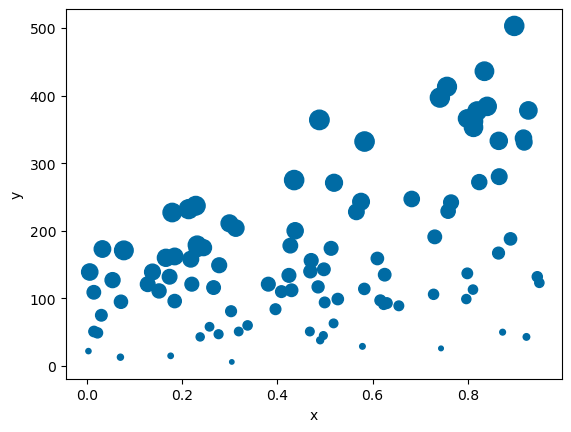

In [29]:
N = 100
rng = np.random.default_rng(123)

x = rng.uniform(0, 1, size=N)
m = rng.choice(range(10, 200), size=N)
lam = np.exp(x)
y = rng.poisson(lam * m)

plt.scatter(x, y, s=m)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


マーカーのサイズが人口を表します。明らかに、人口が大きいほど観測値$y$も大きいので、人口の多寡の影響を統制して、人口あたりの期待値$\lambda$に$x$が与える影響を調べたいとします。

ちなみに、$y/m$を縦軸にとった散布図を書くと下のようになります。これでも大まかな傾向は分かります。

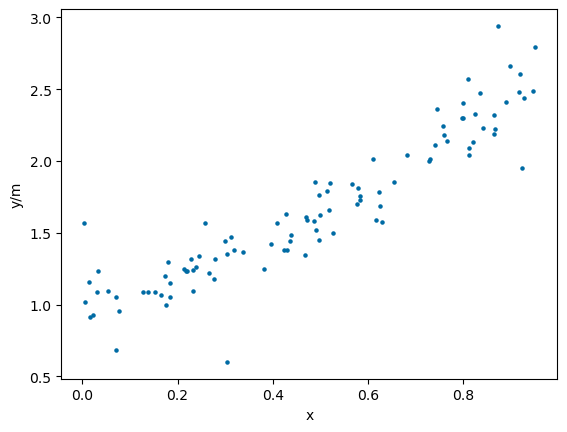

In [30]:
plt.scatter(x, y / m, s=5)
plt.xlabel("x")
plt.ylabel("y/m")
plt.show()


In [31]:
df = pd.DataFrame.from_dict({"y": y, "x": x, "m": m})
df.to_csv("toy_data.csv", index=False)


# GLM (ポアソン回帰)

ドキュメント：https://www.statsmodels.org/stable/glm.html

In [32]:
glm = sm.GLM(
    endog=y,
    exog=sm.add_constant(x),
    exposure=m,
    family=sm.families.Poisson(link=sm.families.links.log()),
).fit()
glm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -385.53
Date:                Mon, 24 Apr 2023   Deviance:                       101.57
Time:                        15:16:41   Pearson chi2:                     101.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.018     -0.478      0.633      -0.043       0.026
x1             1.0031      0.028     36.123      0.000       0.949       1.058
==============================================================================
"""

In [33]:
# 比較例として、対数比率を重回帰したものも出しておきます。
ols = sm.OLS(endog=np.log(y / m), exog=sm.add_constant(x)).fit()


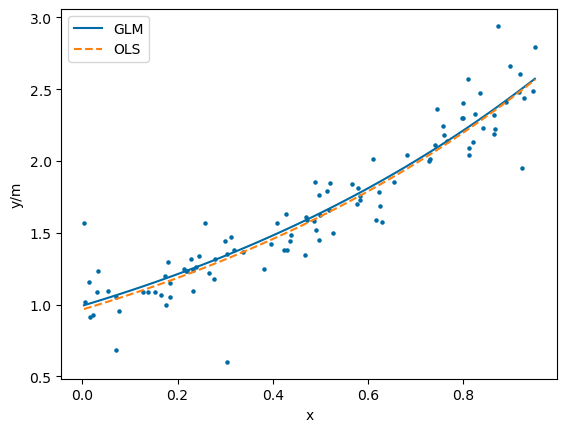

In [34]:
x_line = np.linspace(x.min(), x.max())

plt.scatter(x, y / m, s=5)
plt.plot(x_line, glm.predict(sm.add_constant(x_line), exposure=1), label="GLM")
plt.plot(x_line, np.exp(ols.predict(sm.add_constant(x_line))), label="OLS", ls="--")
plt.legend()
plt.xlabel("x")
plt.ylabel("y/m")
plt.show()


人口あたりの期待値に対して外生変数が割合で効くモデルの場合、被説明変数を対数変換することになります。この場合、観測値$y$がゼロだと$\log y$が発散するので、そのような観測値を取り扱えなくなります。GLMだと$y=0$でも発散しないので、件数がゼロが含まれるデータでも取り扱えるメリットがあります。なお、件数が十分に大きい場合は正規分布での近似精度が良くなるので、重回帰モデル（正規分布モデル）でも似たような結果を得られる場合が多いと考えられます。ただし、条件付き分布の分散がどうなるのかについては念のため考えておいた方が良いでしょう。